In [ ]:
#milestone1

In [1]:
import os
import traceback
import time
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import random
import numpy as np

from azure.common.credentials import ServicePrincipalCredentials
from azure.mgmt.resource import ResourceManagementClient
from azure.mgmt.network import NetworkManagementClient
from azure.mgmt.compute import ComputeManagementClient
from azure.mgmt.compute.models import DiskCreateOption
import datetime

from msrestazure.azure_exceptions import CloudError

from haikunator import Haikunator

In [2]:
haikunator = Haikunator()

###some default settings

# Azure Datacenter
LOCATION = 'westus'

# Resource Group
RESOURCE_GROUP_NAME_PREFIX = 'samza-azure-storage'
# Network
VNET_NAME = 'azure-sample-vnet'
SUBNET_NAME = 'azure-sample-subnet'

# VM
OS_DISK_NAME = 'azure-sample-osdisk'
STORAGE_ACCOUNT_NAME = haikunator.haikunate(delimiter='')

IP_CONFIG_NAME = 'azure-sample-ip-config'
NIC_NAME = 'azure-sample-nic'
USERNAME = 'userlogin'
PASSWORD = 'Pa$$w0rd91'
VM_NAME_PREFIX = 'VM'
VM_SIZE = 'Standard_DS1_v2'

VM_REFERENCE = {
    'linux': {
        'publisher': 'Canonical',
        'offer': 'UbuntuServer',
        'sku': '16.04.0-LTS',
        'version': 'latest'
    },
    'windows': {
        'publisher': 'MicrosoftWindowsServer',
        'offer': 'WindowsServer',
        'sku': '2016-Datacenter',
        'version': 'latest'
    }
}



In [3]:

###Python Client commands


def get_credentials():
    subscription_id = os.environ['AZURE_SUBSCRIPTION_ID']
    credentials = ServicePrincipalCredentials(
        client_id=os.environ['AZURE_CLIENT_ID'],
        secret=os.environ['AZURE_CLIENT_SECRET'],
        tenant=os.environ['AZURE_TENANT_ID']
    )
    return credentials, subscription_id

def create_nic(group_name, network_client, nic_name = NIC_NAME, vnet_name = VNET_NAME, subnet_name = SUBNET_NAME):
    """Create a Network Interface for a VM.
    """
    # Create VNet
    print('\nCreate Vnet')
    async_vnet_creation = network_client.virtual_networks.create_or_update(
        group_name,
        vnet_name,
        {
            'location': LOCATION,
            'address_space': {
                'address_prefixes': ['10.0.0.0/16']
            }
        }
    )
    async_vnet_creation.wait()

    # Create Subnet
    print('\nCreate Subnet')
    async_subnet_creation = network_client.subnets.create_or_update(
        group_name,
        vnet_name,
        subnet_name,
        {'address_prefix': '10.0.0.0/24'}
    )
    subnet_info = async_subnet_creation.result()

    # Create NIC
    print('\nCreate NIC')
    async_nic_creation = network_client.network_interfaces.create_or_update(
        group_name,
        nic_name,
        {
            'location': LOCATION,
            'ip_configurations': [{
                'name': IP_CONFIG_NAME,
                'subnet': {
                    'id': subnet_info.id
                }
            }]
        }
    )
    return async_nic_creation.result()


def create_vm_parameters(nic_id, vm_reference, vm_name, vm_size = VM_SIZE):
    """Create the VM parameters structure.
    """
    return {
        'location': LOCATION,
        'os_profile': {
            'computer_name': vm_name,
            'admin_username': USERNAME,
            'admin_password': PASSWORD
        },
        'hardware_profile': {
            'vm_size': vm_size
        },
        'storage_profile': {
            'image_reference': {
                'publisher': vm_reference['publisher'],
                'offer': vm_reference['offer'],
                'sku': vm_reference['sku'],
                'version': vm_reference['version']
            },
        },
        'network_profile': {
            'network_interfaces': [{
                'id': nic_id,
            }]
        },
    }

#Resource group functions
def resource_group_delete(resource_client, group_name):
    print('\nDelete Resource Group')
    delete_async_operation = resource_client.resource_groups.delete(group_name)
    delete_async_operation.wait()
    print("\nDeleted: {}".format(group_name))

def resource_group_delete_async(resource_client, group_name):
    print('\nDelete Resource Group')
    delete_async_operation = resource_client.resource_groups.delete(group_name)
    print("\nDeleted: {}".format(group_name))    
    

def get_random_resource_group_name():
    return "{}-{}".format(RESOURCE_GROUP_NAME_PREFIX, random.randint(0, 100000000))



#VM functions
def vm_create(group_name, vm_name, compute_client, nic):
    print('\nCreating Linux Virtual Machine')
    vm_parameters = create_vm_parameters(nic.id, VM_REFERENCE['linux'], vm_name)
    async_vm_creation = compute_client.virtual_machines.create_or_update(group_name, vm_name, vm_parameters)
    async_vm_creation.wait()
    # Get the virtual machine by name
    print('\nGet Virtual Machine by Name')
    virtual_machine = compute_client.virtual_machines.get(group_name,vm_name)
    return virtual_machine

# Deallocating the VM (in preparation for a disk resize)
def vm_deallocate(group_name, vm_name, compute_client):
    print('\nDeallocating the VM (to prepare for a disk resize)')
    async_vm_deallocate = compute_client.virtual_machines.deallocate(group_name, vm_name)
    async_vm_deallocate.wait()

def vm_stop(group_name, vm_name, compute_client):
    print('\nStop VM')
    async_vm_stop = compute_client.virtual_machines.power_off(group_name, vm_name)
    async_vm_stop.wait()

def vm_delete(group_name, vm_name, compute_client):
    print('\nDelete VM')
    async_vm_delete = compute_client.virtual_machines.delete(group_name, vm_name)
    async_vm_delete.wait()

def get_random_vm_name():
    return "{}-{}".format(VM_NAME_PREFIX, random.randint(0, 100000000))

#Disk functions
def disk_create(group_name, disk_name, size_gb):
    #print('\nCreate (empty) managed Data Disk')
    async_disk_creation = compute_client.disks.create_or_update(
            group_name,
            disk_name,
            {
                'location': LOCATION,
                'disk_size_gb': size_gb,
                'creation_data': {
                    'create_option': DiskCreateOption.empty
                }
            }
        )    
    data_disk = async_disk_creation.result()
    return data_disk

# Attach data disk
def disk_attach(group_name, virtual_machine, data_disk, lun_id = 12):
    #print('\nAttach Data Disk')
    virtual_machine.storage_profile.data_disks.append({
            'lun': lun_id,
            'name': data_disk.name,
            'create_option': DiskCreateOption.attach,
            'managed_disk': {
                'id': data_disk.id
            }
        })
    async_disk_attach = compute_client.virtual_machines.create_or_update(
            group_name,
            virtual_machine.name,
            virtual_machine
            )
    async_disk_attach.wait()    

def disk_detach(group_name, virtual_machine, delete_disk_name):
    # Detach data disk
    #print('\nDetach Data Disk')
    data_disks = virtual_machine.storage_profile.data_disks
    data_disks[:] = [disk for disk in data_disks if disk.name != delete_disk_name]
    async_vm_update = compute_client.virtual_machines.create_or_update(
            group_name,
            virtual_machine.name,
            virtual_machine
    )
    virtual_machine = async_vm_update.result()
    return virtual_machine

###RestApi Commands
#  https://docs.microsoft.com/en-us/cli/azure/vm?view=azure-cli-latest#az-vm-create
    
#command line tool 
from subprocess import Popen, PIPE
def run_cmd(cmd, throw_exception = False):
    p = Popen(cmd , shell=True, stdout=PIPE, stderr=PIPE)
    out, err = p.communicate()
    out_str = out.decode("utf-8")
    err_str = err.decode("utf-8") 
    if(throw_exception and err_str != ''):
        raise Exception(err_str)
    return out_str

#Disk
def disk_create_rest(group_name, disk_name, size_gb):
    cli_str = "az disk create --resource-group {} --name {}  --size-gb {}".format(group_name, disk_name, size_gb)
    res = run_cmd(cli_str)
    print(res)

# clone command : az disk create -g MyResourceGroup -n MyDisk2 --source MyDisk
def disk_clone_rest(group_name, disk_name, source_disk_name):
    cli_str = "az disk create --resource-group {} --name {} --source {}".format(group_name, disk_name, source_disk_name)
    res = run_cmd(cli_str)
    print(res)
    
def disk_attach_rest(group_name, virtual_machine_name, disk_name):
    cli_str = "az vm disk attach -g {} --vm-name {} --name {}".format(group_name, virtual_machine_name, disk_name)
    #print(cli_str)
    res = run_cmd(cli_str)
    print(res)

def disk_detach_rest(group_name, virtual_machine_name, disk_name):
    cli_str = "az vm disk detach -g {} --vm-name {} --name {}".format(group_name, virtual_machine_name, disk_name)
    #print(cli_str)
    res = run_cmd(cli_str)
    print(res)
    
def create_vm_with_setup_script(group_name, vm_name, config_file_name, disk_name_list):
    disk_str = ""
    for disk_name in disk_name_list:
        disk_str += disk_name + " "
    cli = "az vm create --resource-group {} --name {} --image OpenLogic:CentOS:7-CI:latest --custom-data {} --attach-data-disks {}".format(
        group_name, vm_name, config_file_name, disk_str)
    run_cmd(cli)

In [4]:
credentials, subscription_id = get_credentials()
resource_client = ResourceManagementClient(credentials, subscription_id)
compute_client = ComputeManagementClient(credentials, subscription_id)
network_client = NetworkManagementClient(credentials, subscription_id)

In [5]:
'''

Test1:
Goal: test the disk create delay, mounting and unmounting delay

Parameters: disk sizes 1GB, 1000GB, 10000GB

Procedure:
    1. Create a VM 
    2. Create a disk and measure the delay
    3. Mount a disk to a VM and measure the delay
    4. Unmount a disk from a VM and measure the delay

Result: the mounting and unmounting delay are all very stable and are all around 30 seconds

Follow up tests: 
    1. Need to test the warn-up latency of the disks
    
Reference documents:
    [1] https://github.com/Azure-Samples/virtual-machines-python-manage 

'''
def test_1(test_disk_size_list = [1, 10, 100, 1000]):
    group_name = get_random_resource_group_name()
    vm_name = get_random_vm_name()
    print('\nCreate Resource Group {}'.format(group_name))
    resource_client.resource_groups.create_or_update(group_name, {'location': LOCATION})
    try:
        avg_time_create_disk = []
        avg_time_attach_disk = []
        avg_time_detach_disk = []
        
        # Create a NIC
        nic = create_nic(group_name, network_client)
        # Create Linux VM
        virtual_machine = vm_create(group_name, vm_name, compute_client, nic)
        REPEAT_TIMES = 10
        print("start testing")
        time_every_create = []
        time_every_attach = []
        time_every_detach = []
        for disk_size in test_disk_size_list:
            print("testing disk size : {}".format(disk_size))
            total_create_time = 0
            total_attach_time = 0
            total_detach_time = 0
            for i in range(REPEAT_TIMES):
                disk_name = "disk_{}_{}".format(disk_size, i)
                # Create managed data disk
                start = time.time()
                data_disk = disk_create(group_name, disk_name, disk_size)
                delay = time.time() - start
                total_create_time += delay
                time_every_create.append(delay)
                # Attach data disk
                start = time.time()
                disk_attach(group_name, virtual_machine, data_disk)
                delay = time.time() - start
                time_every_attach.append(delay)
                total_attach_time += delay
                # Detach data disk
                start = time.time()
                disk_detach(group_name, virtual_machine, disk_name)
                delay = time.time() - start
                total_detach_time += delay
                time_every_detach.append(delay)
            avg_time_create_disk.append(total_create_time / REPEAT_TIMES)
            avg_time_attach_disk.append(total_attach_time / REPEAT_TIMES)
            avg_time_detach_disk.append(total_detach_time / REPEAT_TIMES)
        
        #plot the result
        # data to plot
        n_groups = len(test_disk_size_list)

        # create plot
        fig, ax = plt.subplots()
        index = np.arange(n_groups)
        bar_width = 0.2
        opacity = 0.8

        rects1 = plt.bar(index, avg_time_create_disk, bar_width,
        alpha=opacity,
        color='r',
        label='avg_time_create_disk')

        rects2 = plt.bar(index + bar_width, avg_time_attach_disk, bar_width,
        alpha=opacity,
        color='g',
        label='avg_time_attach_disk')
        
        rects3 = plt.bar(index + 2 * bar_width, avg_time_detach_disk, bar_width,
        alpha=opacity,
        color='b',
        label='avg_time_detach_disk')
        
        plt.xlabel('Disk Size in GB')
        plt.ylabel('Time in second')
        plt.title('Disk mounting and unmounting time base on size')
        plt.xticks(index + bar_width, test_disk_size_list)
        plt.legend()

        plt.tight_layout()
        plt.show()
        
        
        print("detail delay of every operation")
        print("create : {}".format(time_every_create))
        print("attach : {}".format(time_every_attach))
        print("detach : {}".format(time_every_detach))
        
    except CloudError:
        print('A VM operation failed:\n{}'.format(traceback.format_exc()))
    else:
        print('All example operations completed successfully!')
    finally:
        resource_group_delete_async(resource_client, group_name)


Create Resource Group samza-azure-storage-41735647

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name
start testing
testing disk size : 1
testing disk size : 1000
testing disk size : 10000


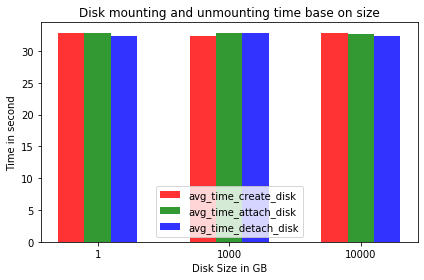

All example operations completed successfully!

Delete Resource Group

Deleted: samza-azure-storage-41735647


In [6]:
test_1()

In [32]:
'''
Test_1_1 : 
test whether the attach and detach behaviour are stable

'''

def test_1_1():
    group_name = get_random_resource_group_name()
    vm_name = get_random_vm_name()
    print('\nCreate Resource Group {}'.format(group_name))
    resource_client.resource_groups.create_or_update(group_name, {'location': LOCATION})
    disk_size = 1000
    try:
        avg_time_create_disk = []
        avg_time_attach_disk = []
        avg_time_detach_disk = []
        
        # Create a NIC
        nic = create_nic(group_name, network_client)
        # Create Linux VM
        virtual_machine = vm_create(group_name, vm_name, compute_client, nic)
        REPEAT_TIMES = 5
        print("start testing")
        
        print("testing disk size : {}".format(disk_size))
        total_create_time = []
        total_attach_time = []
        total_detach_time = []
        for i in range(REPEAT_TIMES):
            disk_name = "disk_{}_{}".format(disk_size, i)
            # Create managed data disk
            start = time.time()
            data_disk = disk_create(group_name, disk_name, disk_size)
            total_create_time.append(time.time() - start)
            # Attach data disk
            start = time.time()
            disk_attach(group_name, virtual_machine, data_disk)
            total_attach_time.append(time.time() - start)
            # Detach data disk
            start = time.time()
            disk_detach(group_name, virtual_machine, disk_name)
            total_detach_time.append(time.time() - start)
        print("create time : {}".format(total_create_time))
        print("attach time : {}".format(total_attach_time))
        print("detach time : {}".format(total_detach_time))
        
    except CloudError:
        print('A VM operation failed:\n{}'.format(traceback.format_exc()))
    else:
        print('All example operations completed successfully!')
    finally:
        resource_group_delete_async(resource_client, group_name)

In [33]:
test_1_1()


Create Resource Group samza-azure-storage-44613244

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name
start testing
testing disk size : 1000
create time : [32.823976278305054, 32.43768000602722, 32.674782037734985, 32.590303897857666, 32.54283881187439]
attach time : [32.564769983291626, 32.881627798080444, 32.545912981033325, 32.54608416557312, 33.40148305892944]
detach time : [32.572230100631714, 32.488401889801025, 32.853878021240234, 32.96618294715881, 32.87084221839905]
All example operations completed successfully!

Delete Resource Group

Deleted: samza-azure-storage-44613244


In [35]:
#test create, attach, detach time for a long time period

time_every_create = []
time_every_attach = []
time_every_detach = []
timeline = []

def test_1_2(test_disk_size_list = [1000], interval = 600):
    
    while True:
        currentDT = datetime.datetime.now()
        print (str(currentDT))
        timeline.append(str(currentDT))
        group_name = get_random_resource_group_name()
        vm_name = get_random_vm_name()
        print('\nCreate Resource Group {}'.format(group_name))
        resource_client.resource_groups.create_or_update(group_name, {'location': LOCATION})
        try:

            # Create a NIC
            nic = create_nic(group_name, network_client)
            # Create Linux VM
            virtual_machine = vm_create(group_name, vm_name, compute_client, nic)
            print("start testing")

            for disk_size in test_disk_size_list:
                disk_name = "disk_{}".format(disk_size)
                # Create managed data disk
                start = time.time()
                data_disk = disk_create(group_name, disk_name, disk_size)
                delay = time.time() - start
                time_every_create.append(delay)
                # Attach data disk
                start = time.time()
                disk_attach(group_name, virtual_machine, data_disk)
                delay = time.time() - start
                time_every_attach.append(delay)
                # Detach data disk
                start = time.time()
                disk_detach(group_name, virtual_machine, disk_name)
                delay = time.time() - start
                time_every_detach.append(delay)
            print("time every create : {}".format(time_every_create))
            print("time every attach : {}".format(time_every_attach))
            print("time every detach : {}".format(time_every_detach))
            print("timeline : {}".format(timeline))
        except CloudError:
            print('A VM operation failed:\n{}'.format(traceback.format_exc()))
        else:
            print('All example operations completed successfully!')
        finally:
            resource_group_delete_async(resource_client, group_name)
            
        time.sleep(interval) 

In [27]:
#start to run at June 13, 2019, 3:34pm - 
test_1_2()


Create Resource Group samza-azure-storage-55387907

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name
start testing
time every create : [32.316981077194214]
time every attach : [32.401090145111084]
time every detach : [32.13862895965576]
All example operations completed successfully!

Delete Resource Group

Deleted: samza-azure-storage-55387907

Create Resource Group samza-azure-storage-81055663

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name
start testing
time every create : [32.316981077194214, 32.748085737228394]
time every attach : [32.401090145111084, 32.63655710220337]
time every detach : [32.13862895965576, 31.822359085083008]
All example operations completed successfully!

Delete Resource Group

Deleted: samza-azure-storage-81055663

Create Resource Group samza-azure-storage-80328520

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine 


Deleted: samza-azure-storage-13531266

Create Resource Group samza-azure-storage-68659079

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name
start testing
time every create : [32.316981077194214, 32.748085737228394, 32.67239689826965, 33.7268807888031, 32.691620111465454, 32.817326068878174, 32.675013065338135, 32.67833113670349, 32.9514799118042, 32.66812705993652, 33.02471995353699, 32.44666600227356, 32.26330900192261]
time every attach : [32.401090145111084, 32.63655710220337, 32.36520218849182, 32.432697057724, 32.40101599693298, 32.60737180709839, 32.70145297050476, 32.729902029037476, 32.693028926849365, 32.73553824424744, 32.47698473930359, 32.31314206123352, 32.36806011199951]
time every detach : [32.13862895965576, 31.822359085083008, 32.64690828323364, 32.87136793136597, 33.048187017440796, 32.52480888366699, 33.14488410949707, 32.897507190704346, 32.800727128982544, 32.73169302940369, 32.703370094299316, 32.588521003723145,


Deleted: samza-azure-storage-96860466

Create Resource Group samza-azure-storage-14413256

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name
start testing
time every create : [32.316981077194214, 32.748085737228394, 32.67239689826965, 33.7268807888031, 32.691620111465454, 32.817326068878174, 32.675013065338135, 32.67833113670349, 32.9514799118042, 32.66812705993652, 33.02471995353699, 32.44666600227356, 32.26330900192261, 32.471394062042236, 32.929139137268066, 30.85251784324646, 30.769285202026367, 30.601657152175903, 30.597524881362915, 30.631196975708008]
time every attach : [32.401090145111084, 32.63655710220337, 32.36520218849182, 32.432697057724, 32.40101599693298, 32.60737180709839, 32.70145297050476, 32.729902029037476, 32.693028926849365, 32.73553824424744, 32.47698473930359, 32.31314206123352, 32.36806011199951, 32.46688365936279, 32.905373096466064, 30.940953969955444, 30.91671895980835, 30.925699949264526, 30.84112095832824

KeyboardInterrupt: 

In [36]:
#start to run at 2019-06-14 09:47:07 - 2019-06-14 12:56:08
test_1_2()

2019-06-14 09:47:07.813092

Create Resource Group samza-azure-storage-63130787

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name
start testing
time every create : [32.54380393028259]
time every attach : [32.75950527191162]
time every detach : [32.76788377761841]
timeline : ['2019-06-14 09:47:07.813092']
All example operations completed successfully!

Delete Resource Group

Deleted: samza-azure-storage-63130787
2019-06-14 10:00:17.470231

Create Resource Group samza-azure-storage-15815266

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name
start testing
time every create : [32.54380393028259, 32.71323919296265]
time every attach : [32.75950527191162, 33.08285593986511]
time every detach : [32.76788377761841, 32.09349513053894]
timeline : ['2019-06-14 09:47:07.813092', '2019-06-14 10:00:17.470231']
All example operations completed successfully!

Delete Resource Group

Deleted: samza-azure-


Deleted: samza-azure-storage-91060300
2019-06-14 11:58:53.028710

Create Resource Group samza-azure-storage-27385922

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name
start testing
time every create : [32.54380393028259, 32.71323919296265, 32.66873812675476, 32.534149169921875, 32.501953125, 32.86650109291077, 32.002777099609375, 33.042635917663574, 32.84106492996216, 31.808740854263306, 32.411089181900024]
time every attach : [32.75950527191162, 33.08285593986511, 32.52201700210571, 32.73306179046631, 32.50752305984497, 32.87834882736206, 32.20262694358826, 32.75561332702637, 32.9456729888916, 33.2202513217926, 32.83735108375549]
time every detach : [32.76788377761841, 32.09349513053894, 32.70710301399231, 32.43898820877075, 32.7152886390686, 33.05429410934448, 32.48059391975403, 32.795592308044434, 32.00991892814636, 33.00447201728821, 32.34207487106323]
timeline : ['2019-06-14 09:47:07.813092', '2019-06-14 10:00:17.470231', '2019-0

ConnectionError: HTTPSConnectionPool(host='login.microsoftonline.com', port=443): Max retries exceeded with url: /72f988bf-86f1-41af-91ab-2d7cd011db47/oauth2/token (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x111c9dc88>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

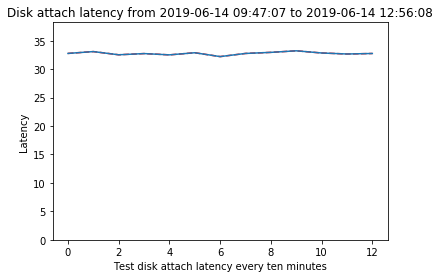

In [11]:
attach_time = [32.75950527191162, 33.08285593986511, 32.52201700210571, 32.73306179046631, 32.50752305984497, 32.87834882736206, 32.20262694358826, 32.75561332702637, 32.9456729888916, 33.2202513217926, 32.83735108375549, 32.66005563735962, 32.748316049575806]


f, ax = plt.subplots(1)
l1=plt.plot(attach_time,'r--',label='type1')
plt.title('Disk attach latency from 2019-06-14 09:47:07 to 2019-06-14 12:56:08')
plt.xlabel('Test disk attach latency every ten minutes')
plt.ylabel('Latency')
ax.set_ylim(0, max(attach_time) + 5)
plt.plot(attach_time)
plt.show()


In [16]:
'''
Test2  

Goal: Test whether we can mount a disk to multiple VMs at the same time.

Procedure:
    1. Create vm1 and vm2
    2. Create disk1
    3. Mount disk1 to vm1
    4. Mount disk1 to vm2

Result: the program returns an error, which means that we can not do that.

Follow up tests: 
    1. Test the disk mount-movement latency

'''
def test_2():
    group_name = get_random_resource_group_name()
    
    print('\nCreate Resource Group {}'.format(group_name))
    resource_client.resource_groups.create_or_update(group_name, {'location': LOCATION})
    try:
        
        # create two VM under the same nic and mount the same disk under them
        #create_nic(group_name, network_client, nic_name = NIC_NAME, vnet_name = VNET_NAME, subnet_name = SUBNET_NAME):
        nic1 = create_nic(group_name, network_client, nic_name = "nic1",vnet_name = "vnet1", subnet_name = "subnet1")
        nic2 = create_nic(group_name, network_client, nic_name = "nic2",vnet_name = "vnet2", subnet_name = "subnet2")
        
        virtual_machine1 = vm_create(group_name, "vm1", compute_client, nic1)
        virtual_machine2 = vm_create(group_name, "vm2", compute_client, nic2)
        
        data_disk = disk_create(group_name, "disk1", 100)
        disk_attach(group_name, virtual_machine1, data_disk)
        disk_attach(group_name, virtual_machine2, data_disk)
        
    except CloudError:
        print('A VM operation failed:\n{}'.format(traceback.format_exc()))
    else:
        print('All example operations completed successfully!')
    finally:
        resource_group_delete_async(resource_client, group_name)

In [17]:
test_2()


Create Resource Group samza-azure-storage-48489271

Create Vnet

Create Subnet

Create NIC

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name

Creating Linux Virtual Machine

Get Virtual Machine by Name
A VM operation failed:
Traceback (most recent call last):
  File "<ipython-input-16-93ada938e2d4>", line 26, in test_disk_mounting_under_multiple_vm
    disk_attach(group_name, virtual_machine2, data_disk)
  File "<ipython-input-15-88c3c558de7b>", line 162, in disk_attach
    virtual_machine
  File "/usr/local/lib/python3.7/site-packages/azure/mgmt/compute/v2019_03_01/operations/virtual_machines_operations.py", line 298, in create_or_update
    **operation_config
  File "/usr/local/lib/python3.7/site-packages/azure/mgmt/compute/v2019_03_01/operations/virtual_machines_operations.py", line 252, in _create_or_update_initial
    raise exp
msrestazure.azure_exceptions.CloudError: Azure Error: ConflictingUserInput
Message: Disk '/subscription

In [22]:
'''
Test3 : 

Goal: Can we mount a disk to one VM and then delete that VM, and then mount this disk to another VM

Procedure:
    1. Create vm1 and vm2
    2. Create disk1
    3. Mount disk1 to vm1
    4. Delete vm1
    5. Mount disk1 to vm2
    
Parameters: disk size 100GB

Result: 
    Yes. If a VM suddenly go down, we can mount it's disk to another VM. 
    That helps our Samza jobs recover from failure.

Follow up tests: 
    1. Test the mount-movement latency (See test 4)

'''
def test_3():
    group_name = get_random_resource_group_name()
    
    print('\nCreate Resource Group {}'.format(group_name))
    resource_client.resource_groups.create_or_update(group_name, {'location': LOCATION})
    try:
        
        # create two VM under the same nic and mount the same disk under them
        nic1 = create_nic(group_name, network_client, nic_name = "nic1",vnet_name = "vnet1", subnet_name = "subnet1")
        nic2 = create_nic(group_name, network_client, nic_name = "nic2",vnet_name = "vnet2", subnet_name = "subnet2")
        
        virtual_machine1 = vm_create(group_name, "vm1", compute_client, nic1)
        virtual_machine2 = vm_create(group_name, "vm2", compute_client, nic2)
        
        disk_name = "disk1"
        data_disk = disk_create(group_name, disk_name, 100)
        disk_attach(group_name, virtual_machine1, data_disk)
        
        async_vm_delete = compute_client.virtual_machines.delete(group_name, "vm1")
        async_vm_delete.wait()
        
        time.sleep(60)
        
        disk_attach(group_name, virtual_machine2, data_disk)
        
    except CloudError:
        print('A VM operation failed:\n{}'.format(traceback.format_exc()))
    else:
        print('All example operations completed successfully!')
    finally:
        resource_group_delete_async(resource_client, group_name)

In [23]:
test_3()


Create Resource Group samza-azure-storage-60832962

Create Vnet

Create Subnet

Create NIC

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name

Creating Linux Virtual Machine

Get Virtual Machine by Name
All example operations completed successfully!

Delete Resource Group

Deleted: samza-azure-storage-60832962


In [22]:
'''
Test 4 : 

Goal: This is a follow up test of test3. The goal is to test the mount-movement latency of a disk.

Parameters: disk size 100GB

Procedure:
    1. Create vm1 and vm2
    2. Create disk1
    3. Attach disk1 to vm1
    4. Detach disk1 from vm1
    5. Attach disk1 to vm2

Result: the mount-movement latency is about 65 seconds. 

'''

def test_4():
    group_name = get_random_resource_group_name()
    
    print('\nCreate Resource Group {}'.format(group_name))
    resource_client.resource_groups.create_or_update(group_name, {'location': LOCATION})
    try:
        
        # create two VM under the same nic and mount the same disk under them
        #create_nic(group_name, network_client, nic_name = NIC_NAME, vnet_name = VNET_NAME, subnet_name = SUBNET_NAME):
        nic1 = create_nic(group_name, network_client, nic_name = "nic1",vnet_name = "vnet1", subnet_name = "subnet1")
        nic2 = create_nic(group_name, network_client, nic_name = "nic2",vnet_name = "vnet2", subnet_name = "subnet2")
        
        virtual_machine1 = vm_create(group_name, "vm1", compute_client, nic1)
        virtual_machine2 = vm_create(group_name, "vm2", compute_client, nic2)
        
        
        disk_name = "disk1"
        disk_create_rest(group_name, disk_name, 100)
        disk_attach_rest(group_name, virtual_machine1.name, disk_name)
        
        start = time.time()
        disk_detach_rest(group_name, virtual_machine1.name, disk_name)
        
        
        disk_attach_rest(group_name, virtual_machine2.name, disk_name)
        print("mount-movement time {} s".format(time.time() - start))
        
    except CloudError:
        print('A VM operation failed:\n{}'.format(traceback.format_exc()))
    else:
        print('All example operations completed successfully!')
    finally:
        print("finish")
        #resource_group_delete_async(resource_client, group_name)


In [23]:
test_4()


Create Resource Group samza-azure-storage-95078164

Create Vnet

Create Subnet

Create NIC

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name

Creating Linux Virtual Machine

Get Virtual Machine by Name
{
  "creationData": {
    "createOption": "Empty",
    "imageReference": null,
    "sourceResourceId": null,
    "sourceUri": null,
    "storageAccountId": null
  },
  "diskIopsReadWrite": 500,
  "diskMbpsReadWrite": 100,
  "diskSizeGb": 100,
  "diskState": "Unattached",
  "encryptionSettingsCollection": null,
  "hyperVgeneration": "V1",
  "id": "/subscriptions/7f4d51e8-5b9e-4872-ae87-24d99b794487/resourceGroups/samza-azure-storage-95078164/providers/Microsoft.Compute/disks/disk1",
  "location": "westus",
  "managedBy": null,
  "name": "disk1",
  "osType": null,
  "provisioningState": "Succeeded",
  "resourceGroup": "samza-azure-storage-95078164",
  "sku": {
    "name": "Premium_LRS",
    "tier": "Premium"
  },
  "tags": {},
  "timeCrea

In [46]:
'''
Test 5: 

Goal: Try to partition a disk and mount a file system in the vm automatically. There are three kinds of methods
    for doing this. And I use method 3 (upload a shell script to a vm) in this tests. 

Procedure:
    1. create a vm with --custom-data setup.sh parameter, which upload our shell script and execute a series of 
        commands to partition a disk and setup a file system
    2. Login this vm manually and make sure the file system can be used 

Result: 
    1. Success. 

Reference:
    Method 1 : Use cloud init
    [1] https://cloudinit.readthedocs.io/en/latest/index.html

    [2] https://stackoverflow.com/questions/53808638/how-can-i-use-cloud-init-to-load-a-datadisk-on-an-ubuntu-vm-in-azure

    [3] https://docs.microsoft.com/en-us/azure/virtual-machines/linux/tutorial-automate-vm-deployment

    [4] https://docs.microsoft.com/en-us/azure/virtual-machines/linux/using-cloud-init

    Method 2 : Create virtual machine using template
    [1] https://docs.microsoft.com/en-us/azure/virtual-machines/linux/create-ssh-secured-vm-from-template

    [2] https://docs.microsoft.com/en-us/azure/azure-resource-manager/

    Method 3: Attach data disks when create vm
    [1] https://docs.microsoft.com/en-us/cli/azure/vm?view=azure-cli-latest#az-vm-create

'''




def test_5():
    config_file_name = "setup.sh"
    #print("cloud-init config file")
    #print(run_cmd("cat {}".format(config_file_name)))
    
    group_name = get_random_resource_group_name()
    
    print('\nCreate Resource Group {}'.format(group_name))
    resource_client.resource_groups.create_or_update(group_name, {'location': LOCATION})
    try:
        
        disk_name = "disk1"
        disk_create_rest(group_name, disk_name, 100)
        
        create_vm_with_setup_script(group_name, "vm1", config_file_name, [disk_name])
        
        
    except CloudError:
        print('A VM operation failed:\n{}'.format(traceback.format_exc()))
    else:
        print('All example operations completed successfully!')
    finally:
        print("finish")
        #resource_group_delete_async(resource_client, group_name)



In [32]:
test_5()


Create Resource Group samza-azure-storage-345713
{
  "creationData": {
    "createOption": "Empty",
    "imageReference": null,
    "sourceResourceId": null,
    "sourceUri": null,
    "storageAccountId": null
  },
  "diskIopsReadWrite": 500,
  "diskMbpsReadWrite": 100,
  "diskSizeGb": 100,
  "diskState": "Unattached",
  "encryptionSettingsCollection": null,
  "hyperVgeneration": "V1",
  "id": "/subscriptions/7f4d51e8-5b9e-4872-ae87-24d99b794487/resourceGroups/samza-azure-storage-345713/providers/Microsoft.Compute/disks/disk1",
  "location": "westus",
  "managedBy": null,
  "name": "disk1",
  "osType": null,
  "provisioningState": "Succeeded",
  "resourceGroup": "samza-azure-storage-345713",
  "sku": {
    "name": "Premium_LRS",
    "tier": "Premium"
  },
  "tags": {},
  "timeCreated": "2019-06-10T18:52:55.717273+00:00",
  "type": "Microsoft.Compute/disks",
  "zones": null
}

All example operations completed successfully!
finish


In [20]:
'''
Test6: 

Goal: Test parallelized disks mounting. 

Procedure:
    1. Create vm1
    2. Use the async_create api create ten 100GB disks.
    3. Wait for all the creation to finish. Measure the time.
    4. Use the async_attach api to mount ten disks to vm1
    5. Wait for all the mounting to finish. Measure the time.
    
Result:
    1. We can create and attach multiple disks in an async way, which can significantly reduce the creation 
        and mounting time. 


'''

#Disk functions
def disk_create_async(group_name, disk_name, size_gb):
    #print('\nCreate (empty) managed Data Disk')
    async_disk_creation = compute_client.disks.create_or_update(
            group_name,
            disk_name,
            {
                'location': LOCATION,
                'disk_size_gb': size_gb,
                'creation_data': {
                    'create_option': DiskCreateOption.empty
                }
            }
        )    
    #data_disk = async_disk_creation.result()
    return async_disk_creation

# Attach data disk
def disk_attach_async(group_name, virtual_machine, data_disk, lun_id):
    #print('\nAttach Data Disk')
    virtual_machine.storage_profile.data_disks.append({
            'lun': lun_id,
            'name': data_disk.name,
            'create_option': DiskCreateOption.attach,
            'managed_disk': {
                'id': data_disk.id
            }
        })
    async_disk_attach = compute_client.virtual_machines.create_or_update(
            group_name,
            virtual_machine.name,
            virtual_machine
            )
    return async_disk_attach


def test_6():
    group_name = get_random_resource_group_name()
    
    print('\nCreate Resource Group {}'.format(group_name))
    resource_client.resource_groups.create_or_update(group_name, {'location': LOCATION})
    try:
        NUM_DISKS = 3
        nic1 = create_nic(group_name, network_client, nic_name = "nic1",vnet_name = "vnet1", subnet_name = "subnet1")
        
        virtual_machine1 = vm_create(group_name, "vm1", compute_client, nic1)
        
        disk_list_callback = []
        disk_list = []
        start = time.time()
        for i in range(NUM_DISKS):
            disk_name = "disk-{}".format(i)
            disk_callback = disk_create_async(group_name, disk_name, 100)
            disk_list_callback.append(disk_callback)
        
        for i in range(NUM_DISKS):
            disk_list.append(disk_list_callback[i].result())
        
        time_create_disk_async = time.time() - start
        start = time.time()
        disk_attach_callback_list = []
        for i in range(NUM_DISKS):
            call_back = disk_attach_async(group_name, virtual_machine1, disk_list[i], i)
            disk_attach_callback_list.append(call_back)
        for i in range(NUM_DISKS):
            disk_attach_callback_list[i].wait()
        time_mount_disk_async = time.time() - start
        
        #plot the result
        # data to plot
        n_groups = 2

        # create plot
        fig, ax = plt.subplots()
        index = np.arange(n_groups)
        bar_width = 0.2
        opacity = 0.8

        rects1 = plt.bar(index, [30, 30], bar_width,
        alpha=opacity,
        color='r',
        label='sync')

        rects2 = plt.bar(index + bar_width, [time_create_disk_async / NUM_DISKS, time_mount_disk_async / NUM_DISKS], bar_width,
        alpha=opacity,
        color='g',
        label='async')
        
        
        plt.xlabel('sync vs async')
        plt.ylabel('Time in second')
        plt.title('Disk sync time vs async time')
        plt.xticks(index + bar_width, ["disk create", "disk mounting"])
        plt.legend()

        plt.tight_layout()
        plt.show()
        
    except CloudError:
        print('A VM operation failed:\n{}'.format(traceback.format_exc()))
    else:
        print('All example operations completed successfully!')
    finally:
        resource_group_delete_async(resource_client, group_name)


Create Resource Group samza-azure-storage-66849137

Create Vnet

Create Subnet

Create NIC

Creating Linux Virtual Machine

Get Virtual Machine by Name


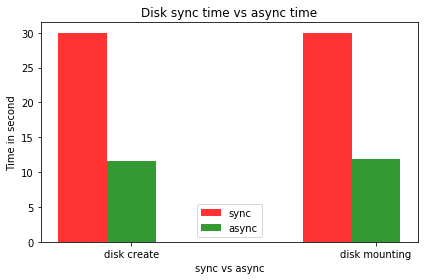

All example operations completed successfully!

Delete Resource Group

Deleted: samza-azure-storage-66849137


In [21]:
test_6()

In [44]:
'''
Test7 : 

Goal : test disk clone latency. This time can help us to measure the cost for a Samza task migrate to another host in
    the cloud environment. 

Parameter: disk size : 1GB, 1000GB, 10000GB

Procedure: 
    1. create a source disk
    2. clone the source disk and measure the time

Result: The time for cloning a disk is around 35 seconds. But this is the time for a empty task. So we need a follow up
    test to test the cloning latency for a full disk. 

'''
def test_7(test_disk_size_list = [1, 1000, 10000]):
    group_name = get_random_resource_group_name()
    vm_name = get_random_vm_name()
    print('\nCreate Resource Group {}'.format(group_name))
    resource_client.resource_groups.create_or_update(group_name, {'location': LOCATION})
    try:
        avg_time_clone_disk = []
        
        REPEAT_TIMES = 3
        print("start testing")
        for disk_size in test_disk_size_list:
            print("testing disk size : {}".format(disk_size))
            source_disk_name = "source-disk-{}".format(disk_size)
            disk_create_rest(group_name, source_disk_name, disk_size)
            total_clone_time = 0
            start = time.time()
            for i in range(REPEAT_TIMES):
                disk_name = "disk_{}_{}".format(disk_size, i)
                # clone disk
                disk_clone_rest(group_name, disk_name, source_disk_name)
            total_clone_time = time.time() - start
            avg_time_clone_disk.append(total_clone_time / REPEAT_TIMES)
            
        #plot the result
        # data to plot
        n_groups = len(test_disk_size_list)

        # create plot
        fig, ax = plt.subplots()
        index = np.arange(n_groups)
        bar_width = 0.2
        opacity = 0.8

        rects1 = plt.bar(index, avg_time_clone_disk, bar_width,
        alpha=opacity,
        color='r',
        label='avg_time_clone_disk')

        
        plt.xlabel('Disk Size in GB')
        plt.ylabel('Time in second')
        plt.title('clone disk latency')
        plt.xticks(index + bar_width, test_disk_size_list)
        plt.legend()

        plt.tight_layout()
        plt.show()
        
    except CloudError:
        print('A VM operation failed:\n{}'.format(traceback.format_exc()))
    else:
        print('All example operations completed successfully!')
    finally:
        resource_group_delete_async(resource_client, group_name)


Create Resource Group samza-azure-storage-69611584
start testing
testing disk size : 1
{
  "creationData": {
    "createOption": "Empty",
    "imageReference": null,
    "sourceResourceId": null,
    "sourceUri": null,
    "storageAccountId": null
  },
  "diskIopsReadWrite": 120,
  "diskMbpsReadWrite": 25,
  "diskSizeGb": 1,
  "diskState": "Unattached",
  "encryptionSettingsCollection": null,
  "hyperVgeneration": "V1",
  "id": "/subscriptions/7f4d51e8-5b9e-4872-ae87-24d99b794487/resourceGroups/samza-azure-storage-69611584/providers/Microsoft.Compute/disks/source-disk-1",
  "location": "westus",
  "managedBy": null,
  "name": "source-disk-1",
  "osType": null,
  "provisioningState": "Succeeded",
  "resourceGroup": "samza-azure-storage-69611584",
  "sku": {
    "name": "Premium_LRS",
    "tier": "Premium"
  },
  "tags": {},
  "timeCreated": "2019-06-10T20:15:06.418380+00:00",
  "type": "Microsoft.Compute/disks",
  "zones": null
}

{
  "creationData": {
    "createOption": "Copy",
    "

{
  "creationData": {
    "createOption": "Copy",
    "imageReference": null,
    "sourceResourceId": "/subscriptions/7f4d51e8-5b9e-4872-ae87-24d99b794487/resourceGroups/samza-azure-storage-69611584/providers/Microsoft.Compute/disks/source-disk-10000",
    "sourceUri": null,
    "storageAccountId": null
  },
  "diskIopsReadWrite": 18000,
  "diskMbpsReadWrite": 750,
  "diskSizeGb": 10000,
  "diskState": "Unattached",
  "encryptionSettingsCollection": null,
  "hyperVgeneration": "V1",
  "id": "/subscriptions/7f4d51e8-5b9e-4872-ae87-24d99b794487/resourceGroups/samza-azure-storage-69611584/providers/Microsoft.Compute/disks/disk_10000_0",
  "location": "westus",
  "managedBy": null,
  "name": "disk_10000_0",
  "osType": null,
  "provisioningState": "Succeeded",
  "resourceGroup": "samza-azure-storage-69611584",
  "sku": {
    "name": "Premium_LRS",
    "tier": "Premium"
  },
  "tags": {},
  "timeCreated": "2019-06-10T20:20:26.669190+00:00",
  "type": "Microsoft.Compute/disks",
  "zones": nu

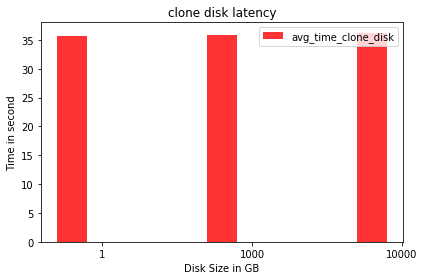

All example operations completed successfully!

Delete Resource Group

Deleted: samza-azure-storage-69611584


In [45]:
test_7()

In [ ]:
'''

Test8:

Goal: test the disk warm-up latency after mounting

vm1,1000GB disk,  1GB file, total 10 files

Running TestDiskWarmUp
Write Time : 22155 millisecond
Write Time : 22197 millisecond
Write Time : 22148 millisecond
Write Time : 22200 millisecond
Write Time : 22199 millisecond
Write Time : 22349 millisecond
Write Time : 22198 millisecond
Write Time : 22203 millisecond
Write Time : 22203 millisecond
Write Time : 22197 millisecond



Personal laptop throughput
Write Time : 3040 millisecond
Write Time : 2930 millisecond
Write Time : 2840 millisecond
Write Time : 3241 millisecond
Write Time : 2864 millisecond
Write Time : 3563 millisecond
Write Time : 2694 millisecond
Write Time : 2723 millisecond
Write Time : 3087 millisecond
Write Time : 3082 millisecond


'''

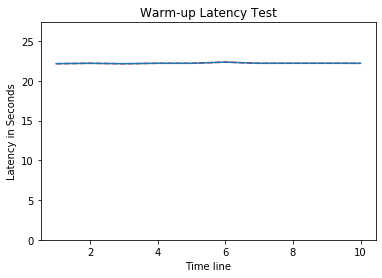

In [12]:
#plot the write latency result
latency = [22.155, 22.197, 22.148, 22.200, 22.199, 22.349, 22.198, 22.203, 22.203, 22.197]
x = np.arange(1, 11, 1)
f, ax = plt.subplots(1)
l1=plt.plot(x,latency,'r--',label='type1')
plt.title('Warm-up Latency Test')
plt.xlabel('Time line')
plt.ylabel('Latency in Seconds')
ax.set_ylim(0, max(latency) + 5)
plt.plot(x, latency)
plt.show()


In [17]:
#test detach a 10GB/1000GB disk
warm_up_group_name = "warmup"
start = time.time()
disk_detach_rest(warm_up_group_name, "vm1", "disk2")
print("detech a 10GB/1000GB disk time : {}".format(time.time() - start))



detech a 10GB/1000GB disk time : 34.60996675491333


In [24]:
'''
Test9 : test the time of clone a disk with content in it

'''

def test_9(source_disk_name):
    group_name = warm_up_group_name
    try:
        avg_time_clone_disk = []
        time_for_each_clone = []
        REPEAT_TIMES = 5
        print("start testing")
            
        total_clone_time = 0
        start = time.time()
        for i in range(REPEAT_TIMES):
            start2 = time.time()
            disk_name = "disk_clone_{}-original-{}".format(i, source_disk_name)
            # clone disk
            disk_clone_rest(group_name, disk_name, source_disk_name)
            time_for_each_clone.append(time.time() - start2)
        total_clone_time = time.time() - start
        avg_time_clone_disk.append(total_clone_time / REPEAT_TIMES)        
        print("average time : ")
        print(avg_time_clone_disk)
        print("time for each clone : ")
        print(time_for_each_clone)
        
    except CloudError:
        print('A VM operation failed:\n{}'.format(traceback.format_exc()))
    else:
        print('All example operations completed successfully!')
    finally:
        print("filish")

In [22]:
test_9()

start testing
{
  "creationData": {
    "createOption": "Copy",
    "imageReference": null,
    "sourceResourceId": "/subscriptions/7f4d51e8-5b9e-4872-ae87-24d99b794487/resourceGroups/warmup/providers/Microsoft.Compute/disks/disk2",
    "sourceUri": null,
    "storageAccountId": null
  },
  "diskIopsReadWrite": 5000,
  "diskMbpsReadWrite": 200,
  "diskSizeGb": 1000,
  "diskState": "Unattached",
  "encryptionSettingsCollection": null,
  "hyperVgeneration": "V1",
  "id": "/subscriptions/7f4d51e8-5b9e-4872-ae87-24d99b794487/resourceGroups/warmup/providers/Microsoft.Compute/disks/disk_clone_0",
  "location": "westus",
  "managedBy": null,
  "name": "disk_clone_0",
  "osType": null,
  "provisioningState": "Succeeded",
  "resourceGroup": "warmup",
  "sku": {
    "name": "Premium_LRS",
    "tier": "Premium"
  },
  "tags": {},
  "timeCreated": "2019-06-12T23:40:47.243255+00:00",
  "type": "Microsoft.Compute/disks",
  "zones": null
}

{
  "creationData": {
    "createOption": "Copy",
    "image

In [25]:
test_9("disk_clone_0")

start testing
{
  "creationData": {
    "createOption": "Copy",
    "imageReference": null,
    "sourceResourceId": "/subscriptions/7f4d51e8-5b9e-4872-ae87-24d99b794487/resourceGroups/warmup/providers/Microsoft.Compute/disks/disk_clone_0",
    "sourceUri": null,
    "storageAccountId": null
  },
  "diskIopsReadWrite": 5000,
  "diskMbpsReadWrite": 200,
  "diskSizeGb": 1000,
  "diskState": "Unattached",
  "encryptionSettingsCollection": null,
  "hyperVgeneration": "V1",
  "id": "/subscriptions/7f4d51e8-5b9e-4872-ae87-24d99b794487/resourceGroups/warmup/providers/Microsoft.Compute/disks/disk_clone_0-original-disk_clone_0",
  "location": "westus",
  "managedBy": null,
  "name": "disk_clone_0-original-disk_clone_0",
  "osType": null,
  "provisioningState": "Succeeded",
  "resourceGroup": "warmup",
  "sku": {
    "name": "Premium_LRS",
    "tier": "Premium"
  },
  "tags": {},
  "timeCreated": "2019-06-13T00:58:27.243506+00:00",
  "type": "Microsoft.Compute/disks",
  "zones": null
}

{
  "crea

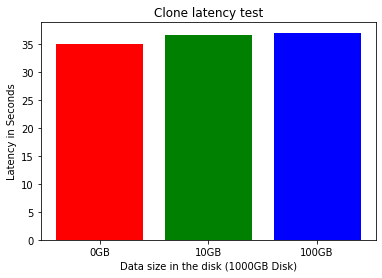

In [21]:
#plot 


#plot the result
name_list = ['0GB','10GB','100GB']  
avg_latency = [35, 36.625593423843384, 37.096701049804686]
plt.title('Clone latency test')
plt.xlabel('Data size in the disk (1000GB Disk)')
plt.ylabel('Latency in Seconds')
plt.bar(range(len(avg_latency)), avg_latency,color='rgb',tick_label=name_list)  
plt.show() 
